In [3]:
import numpy as np
from numpy.random import randn
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import Sampler
from qiskit.circuit import Parameter, Gate
from qiskit.opflow import I, X, Y, Z, PauliOp, MatrixEvolution, MatrixOp
from qiskit.quantum_info import Operator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.tools.visualization import plot_histogram

In [4]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

In [43]:
def zsum(t: Parameter, nqubits, coeffs):
    """ Creates time evolution operator for single-qubit Hamiltonian. Default is Z.
    """
    circ = QuantumCircuit(nqubits)
    for q in range(nqubits):
        circ.p(-t*coeffs[q], q) 
        
    return circ.to_gate(label = 'RZs')

def rodeo_cycle(U, t:Parameter, targ:Parameter, sysqubits:int, coeffs):
    """Prepares a unitary quantum gate for a single cycle of the rodeo algorithm
    without measurements. Contains the parameters t and targ.
    """
    # Prepare registers
    aux = QuantumRegister(1,'a')
    sys = QuantumRegister(sysqubits, 's')
    circuit = QuantumCircuit(aux, sys)
    
    # Add Hadamard test gates
    circuit.h(aux)
    circuit.append(U(t, sysqubits, coeffs).control(1), range(1+sysqubits))
    circuit.p(targ * t,aux)
    circuit.h(aux)
    return circuit.to_gate(label=r'$R_{cyc}$')

In [47]:
# Parameters
cycles = 6
sys_size = 1
targ = Parameter(r'$E_\odot$')
t = [Parameter(fr'$t_{i}$') for i in range(cycles)]

In [50]:
# Create registers and initialize circuit
cbits = ClassicalRegister(cycles, 'c')
aux = QuantumRegister(1, 'a')
sys = QuantumRegister(sys_size, 's')
circ = QuantumCircuit(cbits, aux, sys)

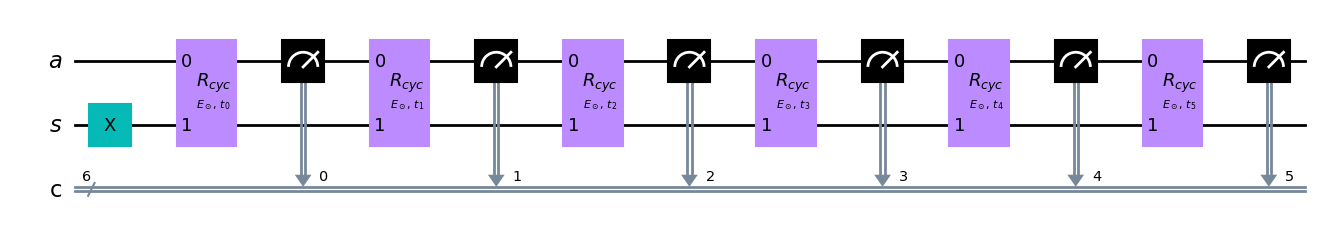

In [51]:
# Construct Hamiltonian
coeffs = [1]*sys_size

circ.x(sys)
# Iteratively construct full rodeo circuit
for cyc in range(cycles):
    circ.append(rodeo_cycle(zsum, t[cyc], targ, sys_size, coeffs), range(1 + sys_size))
    circ.measure(aux, cbits[cyc])
circ.draw(output= 'mpl')

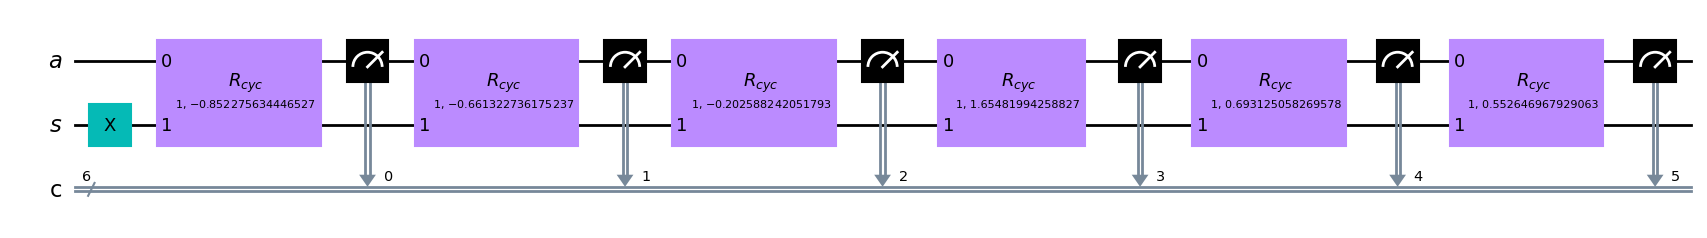

In [72]:
sigma = 1
tsamples = list(sigma * randn(cycles))
targval = sum(coeffs)

paramvals = [targval] + tsamples
circrun = circ.bind_parameters(paramvals)
circrun.draw(output='mpl')

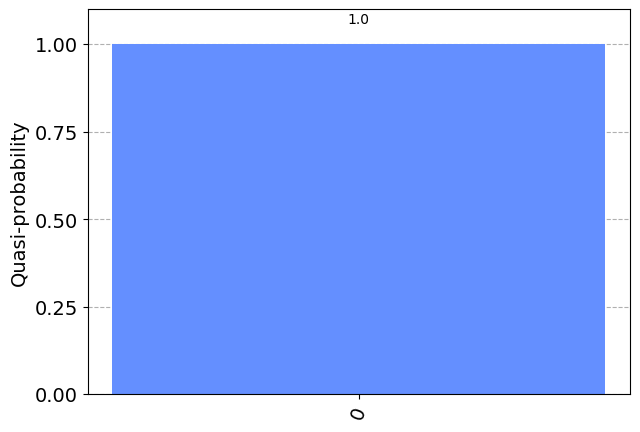

In [73]:
job = sampler.run(circrun)
result = job.result()
plot_histogram(result.quasi_dists[0])

In [62]:
aux = QuantumRegister(1,'a')
sys = QuantumRegister(U.width(), 's')
circuit = QuantumCircuit(2)
circuit.x(0)
circuit = circuit.compose(U,qubits = [1])
circuit.draw()

NameError: name 'U' is not defined

In [ ]:
U = QuantumCircuit(3)
U = U.to_gate()
circ = QuantumCircuit(3)
circ.append(U, qargs = [0,1,2])

In [59]:
exact_evo.parameters

{Parameter(t)}

In [184]:
t = Parameter('t')
targ = Parameter('E')
circ = rodeo_cycle(zsum, t, targ, 1, [1]).draw(output = 'mpl')
circrun = circ.bind_parameters([

In [27]:
sysqubits = 1
coeffs = [1]
t = Parameter('t')
targ = Parameter('E')
# Prepare registers
cbits = ClassicalRegister(1)
aux = QuantumRegister(1,'a')
sys = QuantumRegister(sysqubits, 's')
circuit = QuantumCircuit(cbits,aux, sys)

# Add Hadamard test gates
circuit.h(aux)
circuit.
circuit.p(targ * t,aux)
circuit.h(aux)
circuit.measure(aux,cbits)



circrun.draw()

┌───┐          ┌──────┐┌───┐┌─┐
   a: ┤ H ├────■─────┤ P(3) ├┤ H ├┤M├
      └───┘┌───┴────┐└──────┘└───┘└╥┘
   s: ─────┤ RZs(3) ├──────────────╫─
           └────────┘              ║ 
c4: 1/═════════════════════════════╩═
                                   0

In [28]:
sampler = Sampler(session=backend)

In [34]:
circrun = circuit.bind_parameters([1,4.5])
job = sampler.run(circrun)
result = job.result()
print(result)

SamplerResult(quasi_dists=[{0: 0.37875, 1: 0.62125}], metadata=[{'header_metadata': {}, 'shots': 4000}])


In [36]:
circuit.parameters

ParameterView([Parameter(E), Parameter(t)])